# <center>ISsoft ML Meetups

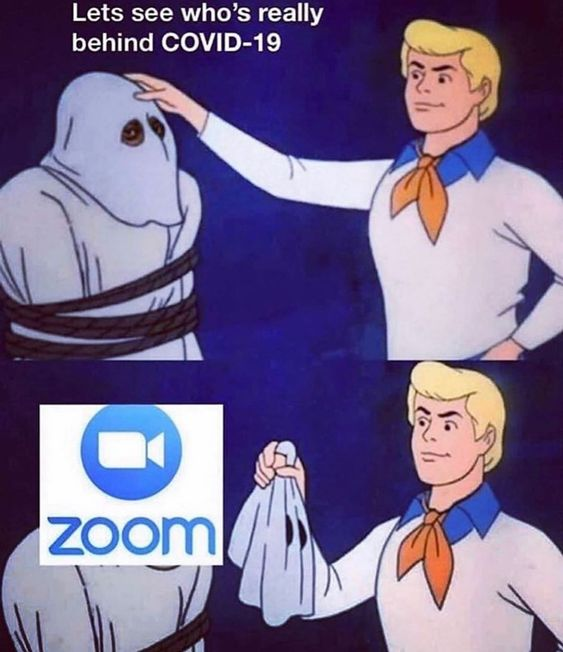

Данное соревнование создано при активном участии ВОЗ и Национальной Академиии наук, техники и медицины. Целью является прогнозирование усредненного уровня заболевших и умерших для различных регионов по всему миру. В первой части митапа проведем исследовательский анализ данных и построим benchmark-модель, которая будет делать предсказание, зависящее от количества и плотности населения. Подробную информацию о соревновании можно найти здесь: https://www.kaggle.com/c/covid19-global-forecasting-week-5/overview.

## Этап 1. Исследовательский анализ данных (exploratory data analysis)

In [ ]:
# подгружаем основные библиотеки
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Данные предоставлены центром системных наук и инженерии университета Джона Хопкинса. Их можно скачать по ссылке: https://www.kaggle.com/c/covid19-global-forecasting-week-5/data

In [ ]:
#Путь к данным
#ВАЖНО! При локальной работе с данными поменяйте это на местоположение данных на вашей машине

df = pd.read_csv('<dataset/ML_Weekly/2/covid_train.csv>', low_memory=False)

In [ ]:
df

Id County Province_State  ...        Date          Target  TargetValue
0            1    NaN            NaN  ...  2020-01-23  ConfirmedCases            0
1            2    NaN            NaN  ...  2020-01-23      Fatalities            0
2            3    NaN            NaN  ...  2020-01-24  ConfirmedCases            0
3            4    NaN            NaN  ...  2020-01-24      Fatalities            0
4            5    NaN            NaN  ...  2020-01-25  ConfirmedCases            0
...        ...    ...            ...  ...         ...             ...          ...
969635  969636    NaN            NaN  ...  2020-06-08      Fatalities            0
969636  969637    NaN            NaN  ...  2020-06-09  ConfirmedCases           27
969637  969638    NaN            NaN  ...  2020-06-09      Fatalities            0
969638  969639    NaN            NaN  ...  2020-06-10  ConfirmedCases            6
969639  969640    NaN            NaN  ...  2020-06-10      Fatalities            0

[969640 rows x 9 columns]

#### Описание данных:
**County** - Название округа <br>
**Province_State** - Название провинции или штата <br>
**Country_Region** - Название страны <br>
**Population** - Население <br>
**Weight** - Плотность населения <br>
**Date** - Дата <br>
**Target** - Бинарный признак (случай заражения или смертельный случай) <br>
**TargetValue** - Количество случаев заражения или смертей <br>

In [ ]:
# Удалим ненужный признак
df.drop(['Id'], axis=1, inplace=True)

In [ ]:
# Найдем в каких временных пределах находятся наши данные
df['Date'].min(), df['Date'].max()

('2020-01-23', '2020-06-10')

In [ ]:
# Распределение записей по странам
df['Country_Region'].value_counts(normalize=True)

US                0.923477
China             0.009818
Canada            0.003754
United Kingdom    0.003176
France            0.003176
                    ...   
Kyrgyzstan        0.000289
Zimbabwe          0.000289
Brazil            0.000289
Japan             0.000289
Azerbaijan        0.000289
Name: Country_Region, Length: 187, dtype: float64

In [ ]:
# Статистическое описание числовых признаков
df.describe()

Population         Weight    TargetValue
count  9.696400e+05  969640.000000  969640.000000
mean   2.720127e+06       0.530870      12.563518
std    3.477771e+07       0.451909     302.524795
min    8.600000e+01       0.047491  -10034.000000
25%    1.213300e+04       0.096838       0.000000
50%    3.053100e+04       0.349413       0.000000
75%    1.056120e+05       0.968379       0.000000
max    1.395773e+09       2.239186   36163.000000

In [ ]:
# Срез с отрицательными значениями 'TargetValue'
df_negative = df[(df['TargetValue'] < 0)]

In [ ]:
# Сортировка среза по признаку 'TargetValue'
df_negative.sort_values(by='TargetValue').head(5)

County Province_State  ...          Target  TargetValue
63464    NaN            NaN  ...  ConfirmedCases       -10034
35826    NaN            NaN  ...  ConfirmedCases        -2850
35754    NaN            NaN  ...  ConfirmedCases        -2512
35740    NaN            NaN  ...  ConfirmedCases        -2206
63527    NaN            NaN  ...      Fatalities        -1918

[5 rows x 8 columns]

In [ ]:
# Часть данных с отрицательным значением целевой переменной
df_negative.shape[0] / df.shape[0]

0.004730621674023349

In [ ]:
# Берем записи только с неотрицательными значениями 'TargetValue'
df = df[(df['TargetValue'] >= 0)]

### Заполнение пропусков в данных

In [ ]:
# Количество записей со значениями NaN для каждого признака
df.isnull().sum()

County            89463
Province_State    52303
Country_Region        0
Population            0
Weight                0
Date                  0
Target                0
TargetValue           0
dtype: int64

In [ ]:
# Заполнение значений NaN
df.fillna('Unknown', inplace=True)

In [ ]:
df.isnull().sum()

County            0
Province_State    0
Country_Region    0
Population        0
Weight            0
Date              0
Target            0
TargetValue       0
dtype: int64

### Feature Engineering

In [ ]:
# Создадим признак 'Location', содержащий в себе всю информацию о метоположении
df['Location'] = df['Country_Region'] + '_' + df['Province_State'] + '_' + df['County']
df. sample(3)

County Province_State  ... TargetValue                   Location
53842   Unknown        Unknown  ...           0  Nicaragua_Unknown_Unknown
485135    Smith    Mississippi  ...           0       US_Mississippi_Smith
97026    La Paz        Arizona  ...           1          US_Arizona_La Paz

[3 rows x 9 columns]

### Обработка нечисловых признаков

In [ ]:
# Преобразование признака, содержащего дату к типу int
def convert_date(df, column):
    redate = pd.to_datetime(df[column], errors='coerce')
    return redate.dt.strftime('%Y%m%d').astype(int)

In [ ]:
df['Date'] = convert_date(df, 'Date')

In [ ]:
# Все уникальные значения признака
df["Target"].unique()

array(['ConfirmedCases', 'Fatalities'], dtype=object)

In [ ]:
# Преобразование строковых значений признака в числовые (label encoding)
df.loc[:, 'Target'] = df['Target'].map({'Fatalities': 0, 'ConfirmedCases': 1})

### Try to do yourself (optional)

Определите дату, когда наблюдался максимальный прирост случаев заболевания в Беларуси.

<font color="red">Варианты ответа:</font>
1. 12.05
2. 24.05
3. 13.04
4. 20.04

In [ ]:
# Ваш код здесь

### Визуализация данных

In [ ]:
# Раскрасим фон градиентом в соответствии с общим количеством умерших для каждой страны
df_fatalities = df[df['Target'] == 0]
fatalities = df_fatalities['TargetValue'].groupby(df_fatalities['Country_Region']).sum().reset_index()
fatalities.sample(10).style.background_gradient(cmap='Blues',subset=["TargetValue"])

In [ ]:
# Найдем общее количество случаев и смертей, а также уровень смертности для каждой страны (отношение умерших ко всем заюолевшим)
df_cases = df[df['Target'] == 1]
cases = df_cases['TargetValue'].groupby(df_cases['Country_Region']).sum().reset_index()
data = pd.merge(cases, fatalities, how='inner', on='Country_Region')
data['Death_rate'] = data['TargetValue_y'] / data['TargetValue_x']
data_sort = data[data['TargetValue_x'] > 1000].sort_values(by='Death_rate', ascending=False)
data_sort.head(10)

Country_Region  TargetValue_x  TargetValue_y  Death_rate
16          Belgium          59569           9629    0.161644
62           France         201351          29541    0.146714
85            Italy         235763          34114    0.144696
177  United Kingdom         292115          41214    0.141088
77          Hungary           4027            551    0.136826
121     Netherlands          48294           6061    0.125502
112          Mexico         129184          15357    0.118877
157           Spain         252686          29054    0.114981
161          Sweden          46814           4795    0.102427
32           Canada         197429          16076    0.081427

In [ ]:
def build_barplot(data, x, y, xlabel, ylabel, title):
    plt.figure(figsize =(10, 5))
    sns.barplot(x=x, y=y, data=data, orient ='v')
    plt.xticks(rotation=30)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title);

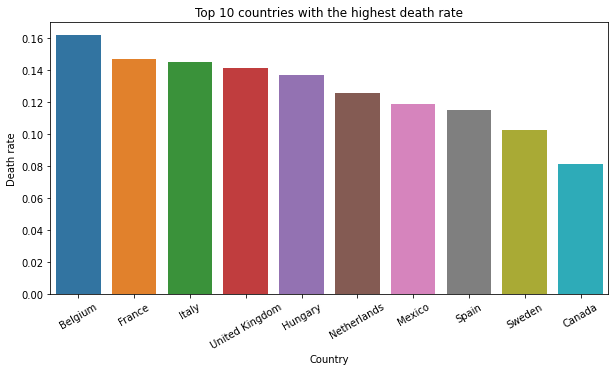

In [ ]:
# Построим barplot топ 10 стран с наивысшим уровнем смертности 
build_barplot(data_sort[:10], 'Country_Region', 'Death_rate', 'Country', 'Death rate', 'Top 10 countries with the highest death rate')

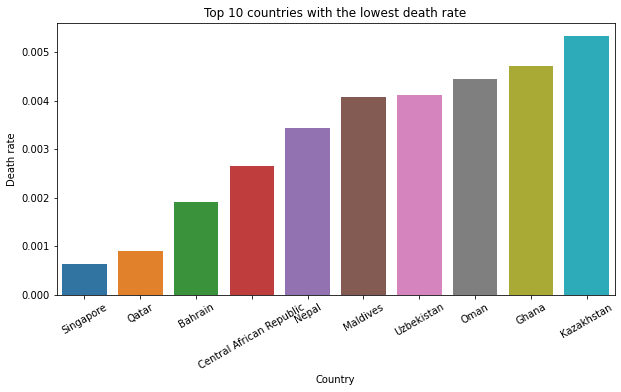

In [ ]:
# Построим barplot топ 10 стран с наименьшим уровнем смертности
data_sort = data_sort.sort_values(by='Death_rate', ascending=True)
build_barplot(data_sort[:10], 'Country_Region', 'Death_rate', 'Country', 'Death rate', 'Top 10 countries with the lowest death rate')

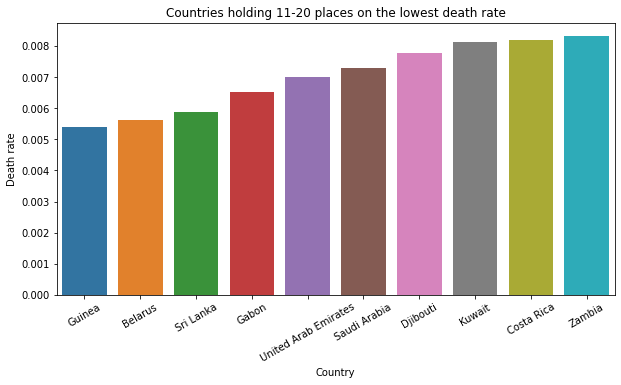

In [ ]:
# Построим barplot стран, занимающих 11-20 места по наименьшему уровню смертности
data_sort = data_sort.sort_values(by='Death_rate', ascending=True)
build_barplot(data_sort[10:20], 'Country_Region', 'Death_rate', 'Country', 'Death rate', 'Countries holding 11-20 places on the lowest death rate')

### Try to do yourself (optional)

Постройте barplot, отображающий топ-10 стран с максимальным уровнем заболеваемости (отношение заболевших к всему населению). Не рассматривайте США и страны с населением меньше 100 тысяч человек.

In [ ]:
# Ваш код здесь

<font color="red">Какая страна находится между Нидерландами и Францией на полученном графике?:</font>
1. Испания
2. Катар
3. Исландия
4. Бахрейн

## Этап 2. Построение Benchmark-модели

In [ ]:
# Разделим датасет на тренировочную и тестовую части
train = df[df['Date'] < 20200513]
test = df[df['Date'] >= 20200513]

In [ ]:
# Выделим датасеты, содержащие информацию только о смертях
train_fatalities = train[train['Target'] == 0]
test_fatalities = test[test['Target'] == 0]

In [ ]:
# Выделим датасеты, содержащие информацию только о заболеваниях
train_cases = train[train['Target'] == 1]
test_cases = test[test['Target'] == 1]

In [ ]:
test_fatalities.sample(3)

County Province_State  ... TargetValue             Location
534227  Prairie        Montana  ...           0   US_Montana_Prairie
823713   Kenedy          Texas  ...           0      US_Texas_Kenedy
936555   Barron      Wisconsin  ...           0  US_Wisconsin_Barron

[3 rows x 9 columns]

In [ ]:
train_cases.sample(3)

County Province_State  ... TargetValue                Location
136180  Tuolumne     California  ...           0  US_California_Tuolumne
914772   Lincoln     Washington  ...           0   US_Washington_Lincoln
675922    Beaver       Oklahoma  ...           0      US_Oklahoma_Beaver

[3 rows x 9 columns]

In [ ]:
# Отделим целевой признак
def select_target_value(train, test, x, y):
    y_train = train[y]
    y_test = test[y]

    X_train = train[x]
    X_test = test[x]
    return X_train, X_test, y_train, y_test

In [ ]:
# Выделим необходимые для модели датасеты
feature_cols = ['Population', 'Weight', 'Date']
X_train_cases, X_test_cases, y_train_cases, y_test_cases = select_target_value(train_cases, test_cases, feature_cols, 'TargetValue')
X_train_fatalities, X_test_fatalities, y_train_fatalities, y_test_fatalities = select_target_value(train_fatalities, test_fatalities, feature_cols, 'TargetValue')

In [ ]:
X_train_cases.sample(3)

Population    Weight      Date
696746     3943079  0.065844  20200316
848420     2102515  0.068688  20200202
650926       53484  0.091851  20200505

In [ ]:
from xgboost import XGBRegressor

**Xgboost** - алгоритм машинного обучения, основанный на дереве поиска решений и градиентном бустинге. На инфографике можно просмотреть эволюцию таких алгоритмов:

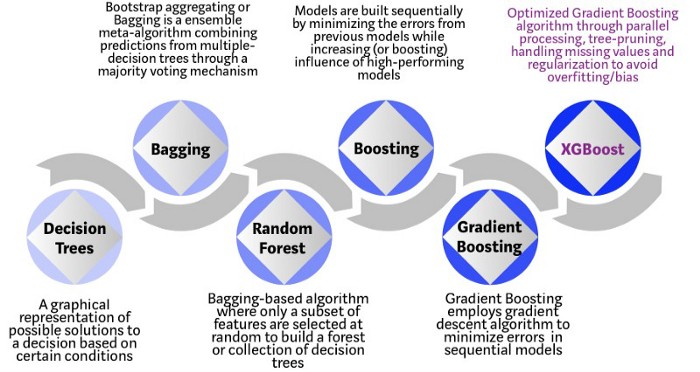

Суть Бустинга, равно как и других ансамблей алгоритмов, состоит в том, чтобы из нескольких слабых моделей собрать одну сильную. Общая идея алгоритмов Бустинга - последовательно применять предикторы так, чтобы каждая последующая модель минимизировала ошибку предыдущей.

boosting.jpg

In [ ]:
from sklearn.metrics import mean_absolute_error

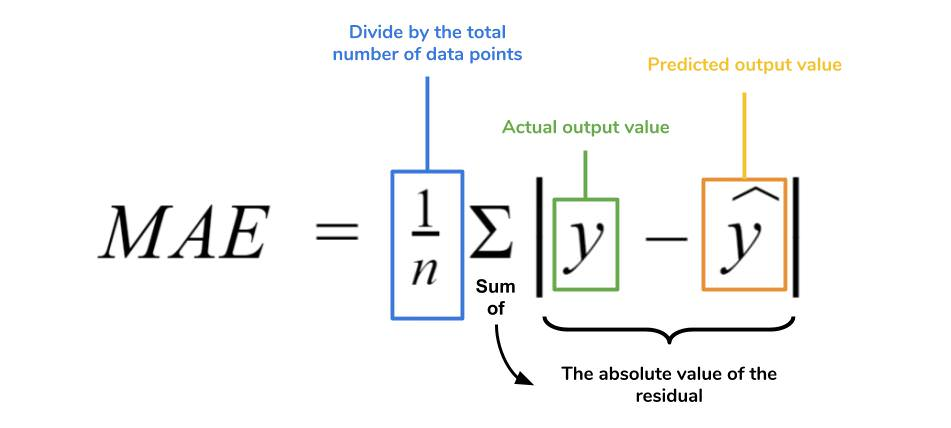

In [ ]:
# Обучим переданную модель, с помощью нее сделаем предсказания и вернем метрику
def apply_model(model, X_train, y_train, X_test, y_test, metric):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metric(y_test, y_pred)

In [ ]:
# Проинициализируем объект класса XGBRegressor и применим эту модель для датасета со смертями
xgb = XGBRegressor(objective ='reg:squarederror', random_state=58, n_jobs=-1)
apply_model(xgb, X_train_fatalities, y_train_fatalities, X_test_fatalities, y_test_fatalities, mean_absolute_error)

2.3878011033815705

In [ ]:
# Применим XGBRegressor для датасета с заболеваниями
apply_model(xgb, X_train_cases, y_train_cases, X_test_cases, y_test_cases, mean_absolute_error)

39.689278233292846

In [ ]:
# Визуализируем предсказание по Беларуси
train_belarus = train_cases[train_cases["Country_Region"] == "Belarus"]
test_belarus = test_cases[test_cases["Country_Region"] == "Belarus"]
sns.lineplot(train_belarus["Date"].values, train_belarus["TargetValue"].values);
sns.lineplot(test_belarus["Date"].values, test_belarus["TargetValue"].values);
sns.lineplot(test_belarus["Date"].values, xgb.predict(test_belarus[['Population', 'Weight', 'Date']]));

In [ ]:
# Выведем ошибку для Беларуси
X_train_belarus, X_test_belarus, y_train_belarus, y_test_belarus = select_target_value(train_belarus, test_belarus, feature_cols, 'TargetValue')
y_pred_belarus = xgb.predict(X_test_belarus)
mean_absolute_error(y_test_belarus, y_pred_belarus)

578.3295772157867

### Итог:

В первой части митапа по глобальному прогнозированию Covid-19 проделана следующая работа:

- Проведели анализ данных
- Нашли пропущенные значения и заполнили их 
- Обработали нечисловые признаки 
- Придумали новый признак (feature enginreering)
- Сделали визуализацию данных
- Построили benchmark-модель

### Полезные ссылки

- [Exploratory Data Analysis](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15)
- [XGBoost](https://medium.com/nuances-of-programming/%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC-xgboost-%D0%BF%D1%83%D1%81%D1%82%D1%8C-%D0%BE%D0%BD-%D1%86%D0%B0%D1%80%D1%81%D1%82%D0%B2%D1%83%D0%B5%D1%82-%D0%B4%D0%BE%D0%BB%D0%B3%D0%BE-dc8c4eca3fbc)
- [Градиентный спуск](https://neurohive.io/ru/osnovy-data-science/gradient-descent/)
- [Градиентный бустинг (Видео)](https://www.youtube.com/watch?v=ow5LdsjzfL0)
- [Градиентный бустинг (Habr)](https://habr.com/ru/company/ods/blog/327250/)